In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai.basics as fai
import fastai.text as ftxt
import pandas as pd

import gc
import torch

In [3]:
path = fai.untar_data(fai.URLs.IMDB)

In [5]:
!ls {path}/train/neg | head

0_3.txt
10000_4.txt
10001_4.txt
10002_1.txt
10003_1.txt
10004_3.txt
1000_4.txt
10005_3.txt
10006_4.txt
10007_1.txt
ls: write error: Broken pipe


In [6]:
def load_text_data(batch_size):
    return (ftxt.TextList.from_folder(path)
            .filter_by_folder(include=['train', 'test', 'unsup']) 
            .split_by_rand_pct(0.1)
            .label_for_lm()           
            .databunch(bs=batch_size))

In [7]:
#data = load_text_data(32)

In [8]:
data.save('data.pkl')

In [9]:
data = ftxt.load_data(path, 'data.pkl', bs=64)

In [10]:
data.show_batch()

idx,text
0,) xxmaj the film is interesting because it is both funny and sad - xxmaj edith died shortly after the film was released ( in xxmaj february 1977 ) aged 82 after experiencing some of the fame that she and xxmaj edie received after the film ( she danced and sang in a nightclub xxmaj edie xxmaj beale xxmaj jr was born in 1925 and is still living in xxmaj
1,"fan of the punk rock group the xxmaj ramones , in "" xxmaj rock ' n ' xxmaj roll xxmaj high xxmaj school "" . xxmaj soles is so exuberant , you do n't mind she 's obviously too old to still be in high school ( that fact is leveled out by having all the kids look 24 ) . xxmaj the movie is a fast - paced frolic"
2,"the poster says . ) xxmaj so a current convict named xxmaj james xxmaj cole ( xxmaj bruce xxmaj willis ) is sent as a "" volunteer "" to get some samples from above . xxmaj after he does his "" volunteer "" work , he is asked to be sent back in time to the year 1996 to figure out what happened to the world . xxmaj cole accepts"
3,"was an exercise in witnessing heroic failure , so i felt the same about part two of xxmaj che ( xxmaj guerilla ) . xxmaj we know at the outset that he dies , we know he fails . xxmaj it is frustrating because the way the story is told , it is obvious fairly early on that the xxunk of revolution in xxmaj bolivia is doomed ; xxmaj che"
4,"near the end . xxmaj while the turn is not absurd , it is certainly not what you expected from the way things had been progressing . \n \n xxmaj moody , atmospheric , and very well done for something that appears to have been shot on video . xxbos xxmaj ultra - grim crime drama from xxmaj pou - xxmaj soi xxmaj cheang , the director of """


In [11]:
data.train_ds[0][0].data[:10]


array([  2,   5, 156, 157,  33, 127,  20,  67,   5,  55])

In [12]:
learner = ftxt.language_model_learner(data_lm, ftxt.AWD_LSTM)

In [14]:
learner.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.677066,4.280885,0.276421,24:13


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


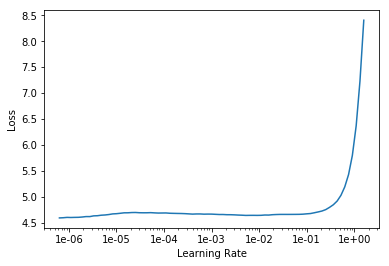

In [15]:
learner.lr_find(); learner.recorder.plot()

In [16]:
learner.save('first_epoch')

In [17]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


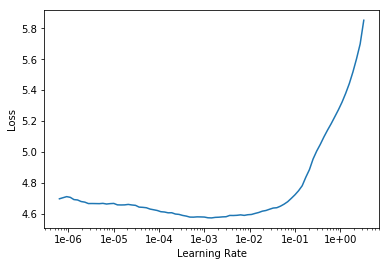

In [18]:
learner.lr_find(); learner.recorder.plot()

In [19]:
learner.fit_one_cycle(5, 2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.229689,4.017335,0.304800,27:27
1,4.151174,3.941037,0.313222,27:26
2,4.094002,3.865438,0.320810,27:24
3,3.994787,3.800896,0.327969,27:27
4,3.899923,3.779623,0.330278,27:25


In [20]:
learner.save("6e-32bs")

In [12]:
learner.load("6e-32bs")

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos i am proud to say i own an uncut copy of this choice chunk of 70 's xxmaj crown xxmaj international drive - in sexploitation comedy cheese on xxup dvd . xxmaj it 's a really goofy and enjoyably inconsequential flick with a nicely xxunk 70 's vibe to it . xxmaj it does attempt to make a sincere point about true love and friendship being more important in life than a cool set of wheels and a quick piece of tail . xxmaj sure , it 's essentially a blatant adolescent male fantasy pic -- the main teen xxunk character xxmaj bobby xxmaj hamilton gets the girls , the respect of his friends , and a chance to show - up a local van - racing bully -- but it 's way too dopey and good - natured to hate . xxmaj stuart xxmaj getz as our gawky protagonist makes for an endearingly dorky lead , xxmaj deborah xxmaj white as the main object of xxmaj getz 's affection is a definite cutie , xxmaj connie xxmaj lisa xxmaj 

In [21]:
learner.validate()

[3.779542, tensor(0.3303)]

En la clase alcanzamos 33.51% Aquí logramos... 33.03%



In [22]:
learner.predict("This movie is awful because", 40, temperature=0.75) #mismo ejemplo

"This movie is awful because it is boring and the characters are so predictable . Although the ending is really a spin - off of what we 'd expect from Lee Van Cleef , Jimmy Stewart , and"

In [23]:
learner.predict("Hitler did", 5, temperature=0.75)

"Hitler did n't know what to do"

In [24]:
learner.predict("Hector is a very", 10, temperature=0.75)

'Hector is a very boy who wants to make a good movie .'

In [25]:
learner.predict("Kagami is", 20, temperature=0.75)

'Kagami is the movie that makes me want to cry . It is not scary . There is a series'

In [27]:
learner.predict("Us just came out", 20, temperature=0.75)

'Us just came out of Japan and said " What will you do in Japan ? " \n \n  The main'

In [22]:
learner.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60004, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60004, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60004, bias=True)
    (output_dp): RNNDropout()
  )
)

In [28]:
learner.save_encoder('language_model')

Para cargar los datos del clasificador, es igual que antes: la única diferencia es que tenemos que explícitamente darle el vocabulario que usaremos (que encontró el language model).

In [30]:
def load_class_data(path, vocab, batch_size):
    return (ftxt.TextList
            .from_folder(path, vocab=vocab)
            .split_by_folder(valid='test')
            .label_from_folder(classes=['neg','pos'])
            .databunch(bs=batch_size))

In [31]:
data = load_class_data(path,data_lm.vocab,10)

In [32]:
data.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos "" a xxmaj damsel in xxmaj distress "" is definitely not one of xxmaj fred xxmaj astaire 's better musicals . xxmaj but even xxmaj astaire 's bad films always had some good moments . \n \n xxmaj in "" xxmaj damsel , "" xxmaj astaire is xxmaj jerry xxmaj halliday , an xxmaj american musical star who is in xxmaj london on a personal appearance tour .",neg
"xxbos xxmaj well , on it 's credit side ( if it can be said to have one ) , xxmaj timothy xxmaj hines xxup did manage to capture the original setting of xxup h.g. xxmaj wells ' outstanding novella . xxmaj but other than that - well , to call a spade a spade - it sucks bigtime . xxmaj what the xxmaj master xxmaj ed xxmaj wood could",neg
"xxbos xxmaj this movie was extremely poorly conceived from every angle except technological . i stood and watched everyone xxunk out of the theater , their faces drained like their lives flashed before their eyes -- eyes wandering at their neighbor , wondering if it was just them . i mean , how could the movie really be bad . xxmaj xxunk admit it , it 's a classic case",neg
"xxbos xxmaj as with all of xxmaj angelopoulos ' films , "" xxmaj the xxmaj suspended xxmaj step of the xxmaj stork "" implicitly demands a close and intimate participation on the part of the viewer , a fact that has certainly contributed to the limited popularity of his work . xxmaj dialogues are sparing , with no monologues or exchanges xxunk the characters ' inner conflicts , doubts ,",pos


- xxbos = begining of sentence
- xxmaj = mayúscula la primera
- xxup = toda la siguiente palabra en mayúsculas
- xxunk = palabra no conocida
- etc.

In [34]:
class_learner = ftxt.text_classifier_learner(data, ftxt.AWD_LSTM, drop_mult=0.5)
class_learner.load_encoder('language_model')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


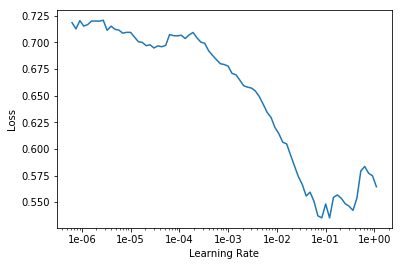

In [36]:
class_learner.lr_find(); class_learner.recorder.plot()

In [37]:
class_learner.fit_one_cycle(1,6e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.320333,0.223842,0.920280,07:43


In [38]:
class_learner.save('stage-1')

In [38]:
len(class_learner.layer_groups)

5

In [42]:
class_learner.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


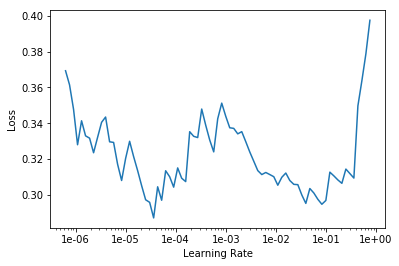

In [43]:
class_learner.lr_find(); class_learner.recorder.plot()

In [44]:
class_learner.fit_one_cycle(1,slice(3e-3,1e-2),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.234268,0.182949,0.933840,08:31


In [46]:
class_learner.save('stage-2')

In [52]:
class_learner.load('stage-2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj why should you watch this ? xxmaj there are certainly no reasons why you should n't watch it ! xxmaj superbly and amusingly directed by xxmaj albert and xxmaj david xxmaj maysles , xxmaj grey xxmaj gardens was originally intended to be a film on the gentrification of xxmaj east xxmaj hampton , but it turned out to the brothers that it would be more interesting to produce a study on the eccentric life of the two xxmaj edith xxmaj bouvier xxmaj beales , the aunt and cousin of xxmaj jacqueline xxmaj kennedy xxmaj onassis . xxmaj their life was certainly an amusing one ( xxmaj edith spent most of her day in bed singing operas , xxmaj edie performing pirouettes and xxunk dances with their many cats , one was named xxmaj ted xxup z. xxmaj kennedy ) xxmaj the film is interesting because it is both funny and sad - xxmaj edith died shortly after the film was released ( in xxmaj february 1977 ) aged 82 aft

In [53]:
class_learner.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


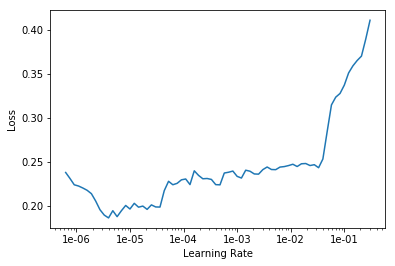

In [49]:
class_learner.lr_find(); class_learner.recorder.plot()

In [54]:
class_learner.fit_one_cycle(1,slice(7e-6,2e-5),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.248462,0.177183,0.937280,11:04


In [56]:
class_learner.save('stage-3')

In [13]:
class_learner.load('stage-3');

In [58]:
class_learner.unfreeze()

In [59]:
gc.collect()
torch.cuda.empty_cache()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


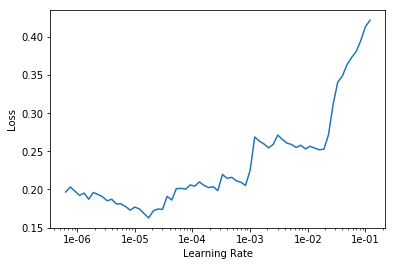

In [60]:
class_learner.lr_find(); class_learner.recorder.plot()

In [61]:
class_learner.fit_one_cycle(2,slice(3e-5,1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.228093,0.169513,0.938160,13:48
1,0.277599,0.165253,0.939960,13:48


Nada mal, considerando que el estado del arte [es ](http://nlpprogress.com/english/sentiment_analysis.html) (del creador de fast.ai, Jeremy Howard), usando exactamente lo mismo (pero con más feature engineering). (Copiado para hacer comparaciones)

Estado del Arte     Acc (0.952)
Resultados de Calse Acc (0.9462)
Resultados aquí     Acc (0.9399)
